In [3278]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt

from src.utils.argparsing import get_args

pd.set_option('display.max_rows', 500)

warnings.filterwarnings("ignore")
sns.set(font="Helvetica")
ROOT = "/Users/sm2152/Documents/projects/feedback-DT/"

In [3279]:
def get_conditioning(row):
    """
    Returns a string describing the conditioning used for a given experiment.
    """
    conditioning = []
    if row["use_rtg"]:
        conditioning.append("rtg")
    if row["use_mission"]:
        conditioning.append("mission")
    if row["use_feedback"]:
        if row["feedback_mode"] != "all":
            conditioning.append(f"{row['feedback_mode']} feedback")
        else:
            conditioning.append("all feedback")
    return " + ".join(conditioning)

In [3280]:
def get_experiments(output_path, dir):
    """
    Returns a list of dataframes containing the results of all experiments in a given directory.
    """
    settings = dir.split("-")[5:]
    dfs = []
    for seed_dir in os.listdir(os.path.join(output_path, dir)):
        exp_path = os.path.join(output_path, os.path.join(dir, seed_dir))
        try:
            df = pd.read_pickle(os.path.join(exp_path, "results.pkl"))
            df["model_seed"] = seed_dir
        except:
            continue
        for s in settings:
            key = s.split("_")[:-1]
            key = "_".join(key)
            value = s.split("_")[-1]
            value = (
                int(value)
                if value.isnumeric()
                else (
                    True if value == "True" else (False if value == "False" else value)
                )
            )
            df[key] = value
        try:
            df["conditioning"] = df.apply(lambda row: get_conditioning(row), axis=1)
        except KeyError:
            raise KeyError("Could not generate conditioning column")
        dfs.append(df)
    return dfs

In [3281]:
def get_combined_df(output_path, level=None):
    """
    Returns a dataframe containing the results of all experiments in a given directory.
    """
    dfs = []
    for dir in os.listdir(output_path):
        if "level" in dir:
            if level and level.lower() not in dir:
                continue
            current_dfs = get_experiments(output_path, dir)
            dfs.extend(current_dfs)
    dfs = [df[(df["eval_type"] != "efficiency") & (df["model"] == "DT")] for df in dfs]
    return pd.concat(dfs, ignore_index=True)

In [3282]:
def aggr_results(df, inference_mode, eval_type, metric):
    """
    Returns a dataframe containing the aggregated results of a given evaluation type.
    """

    filtered_results = df[
        (df["eval_type"] == eval_type)
        & (
            (df["feedback_at_inference"] == inference_mode)
            | (pd.isna(df["feedback_at_inference"]))
        )
    ]

    results = (
        filtered_results[["conditioning",  metric]]
        .groupby(["conditioning"])
        .agg(
            Mean=(metric, "mean"),
            Std=(metric, "std"),
            Min=(metric, "min"),
            Max=(metric, "max"),
        )
    )
    results["ood_type"] = 'all types' if eval_type == "ood_generalisation" else None
    results["eval_type"] = eval_type
    results["feedback_at_inference"] = inference_mode

    if eval_type == "ood_generalisation":
        results_by_ood = (
            filtered_results[["ood_type", "conditioning",  metric]]
            .groupby(["ood_type", "conditioning"])
            .agg(
                Mean=(metric, "mean"),
                Std=(metric, "std"),
                Min=(metric, "min"),
                Max=(metric, "max"),
            )
        )
        results_by_ood["eval_type"] = eval_type
        results_by_ood["feedback_at_inference"] = inference_mode
    else:
        results_by_ood = None

    return results, results_by_ood

In [3283]:
def get_deltas(df, reference):
    """
    Returns a dataframe containing the deltas of a given dataframe with respect to a reference (mission or RTG).
    """
    delta_df = df[
        (df["conditioning"].str.contains(reference))
        | (df["conditioning"] == "all feedback")
    ]
    delta_df["Delta (Mean)"] = delta_df.apply(
        lambda row: row["Mean"]
        - delta_df.loc[delta_df["conditioning"] == reference, "Mean"].values[0],
        axis=1,
    )
    delta_df["reference"] = reference
    return delta_df

In [3284]:
def combine_results(df, metric):
    """
    Returns a dataframe containing the aggregated results of all evaluation types.
    """
    dfs = []
    for reference in ["mission", "rtg"]:
        for inference_mode in df["feedback_at_inference"].unique():
            if pd.isna(inference_mode):
                continue
            for eval_type in df["eval_type"].unique():
                results, results_by_ood = aggr_results(df, inference_mode, eval_type, metric)
                results.reset_index(inplace=True)
                
                results_with_deltas = get_deltas(results, reference)
                dfs.append(results_with_deltas)
                
                if results_by_ood is not None:
                    results_by_ood.reset_index(inplace=True)
                    for ood_type in results_by_ood["ood_type"].unique():
                        results_by_ood_with_deltas = get_deltas(results_by_ood[results_by_ood["ood_type"] == ood_type], reference)
                        dfs.append(results_by_ood_with_deltas)
    return pd.concat(dfs, ignore_index=True)

In [3285]:
def save_results_as_csv(df, level, metric, output_path):
    """
    Saves a dataframe as a csv file.
    """
    path = os.path.join(output_path, f"results_{level}_{metric}.csv")
    df.to_csv(path)

In [3286]:
def map_colors(df, colors):
    """
    Returns a dictionary mapping conditioning variants to colors for plots.
    """
    labels = list(df["conditioning"].unique())
    return {
        label: colors["uoe_si_colors"][i + 1]
        if "mission" in label
        else (
            colors["hwu_colors"][0]
            if label == "all feedback"
            else colors["aarg_colors"][i]
        )
        for i, label in enumerate(labels)
    }


In [3287]:
def set_axis_ticks(ax, reference, reference_perf, ylims, sizing_config):
    """
    Sets the reference performance on the y-axis (instead of 0).
    """
    ax.set_ylim(bottom=-ylims, top=ylims)
    yticklabels = ax.get_yticks().tolist()

    new_yticklabels = [
        f"{reference_perf:.2f}*"
        if float(ytick) == float(0)
        else (f"+{ytick:.2f}" if float(ytick) > float(0) else f"{ytick:.2f}")
        for ytick in yticklabels
    ]
    ax.set_yticklabels(new_yticklabels, fontsize=sizing_config["tick_label_size"])
    xticklabels = ax.get_xticklabels()
    new_xticklabels = [
        f"vs {label.get_text()}".replace(f"vs {reference}", "").replace(
            "feedback", "\nfeedback"
        )
        for label in xticklabels
    ]
    ax.set_xticklabels(new_xticklabels, fontsize=sizing_config["tick_label_size"])
    plt.tight_layout(pad=0.5)

In [3288]:
def set_bar_values(ax, df, ylims, sizing_config):
    """
    Sets the values of the bars on top of the bars (for positive deltas)
    / below the bars (for negatvie deltas).
    """
    for index, value in enumerate(df["Delta (Mean)"]):
        x_pos = index
        y_pos = value + ylims / 25 if value > 0 else value - ylims / 25
        va = "bottom" if value > 0 else "top"
        ax.text(
            x_pos,
            y_pos,
            f"{value:.2f}",
            ha="center",
            va=va,
            fontsize=sizing_config["value_size"],
        )
    plt.tight_layout(pad=0.5)

In [3289]:
def set_pad_title(level, eval_type, inference_mode, sizing_config):
    """
    Sets the title of the plot, with padding.
    """
    if "all" in level:
        level = level.replace('_', ' ')
    else:
        level = "level " + f"'{level}'"
    plt.title(
        f"{eval_type.replace('_', ' ')} on {level} \n({inference_mode} feedback at inference)",
        fontsize=sizing_config["title_size"],
    )
    plt.tight_layout(pad=0.5)

In [3290]:
def set_pad_axis_labels(ax, metric, reference, sizing_config):
    """
    Sets the labels of the x and y axes, with padding.
    """
    ax.set_xlabel(
        "Conditioning variant",
        fontsize=sizing_config["axis_label_size"],
        wrap=True,
    )
    ax.set_ylabel(
        f"Δ {metric.replace('_', ' ')}{' rate' if metric == 'gc_success' else ''}\n*{reference}",
        fontsize=sizing_config["axis_label_size"],
        labelpad=sizing_config["axis_label_size"] * 0.75,
        wrap=True,
    )
    ax.tick_params(axis="both", which="major", pad=-2)
    plt.tight_layout(pad=0.5)

In [3291]:
def get_plot_config(size):
    figma_dpi = 72
    small_height = 132 / figma_dpi
    medium_height = 198 / figma_dpi
    large_height = 396 / figma_dpi
    full_width = 396 / figma_dpi
    half_width = 190.5 / figma_dpi
    third_width = 122 / figma_dpi

    xsmall_font_size = 6
    small_font_size = 9
    medium_font_size = 10
    large_font_size = 14
    xlarge_font_size = 16

    xsmall_font_set = (
        xsmall_font_size,
        xsmall_font_size,
        xsmall_font_size,
        xsmall_font_size,
    )

    small_font_set = (
        small_font_size,
        small_font_size,
        xsmall_font_size,
        xsmall_font_size,
    )
    medium_font_set = (
        large_font_size,
        medium_font_size,
        small_font_size,
        xsmall_font_size,
    )
    large_font_set = (
        xlarge_font_size,
        large_font_size,
        medium_font_size,
        small_font_size,
    )

    if size == "small-third":
        figsize = (third_width, small_height)
        font_sizes = xsmall_font_set
    elif size == "small-half":
        figsize = (half_width, small_height)
        font_sizes = xsmall_font_set
    elif size == "small":
        figsize = (full_width, small_height)
        font_sizes = small_font_set
    elif size == "medium-third":
        figsize = (third_width, medium_height)
        font_sizes = xsmall_font_set
    elif size == "medium-half":
        figsize = (half_width, medium_height)
        font_sizes = small_font_set
    elif size == "medium":
        figsize = (full_width, medium_height)
        font_sizes = medium_font_set
    elif size == "large-third":
        figsize = (third_width, large_height)
        font_sizes = medium_font_set
    elif size == "large-half":
        figsize = (half_width, large_height)
        font_sizes = large_font_set
    else:
        figsize = (full_width, large_height)
        font_sizes = large_font_set

    return {
        "figsize": figsize,
        "title_size": font_sizes[0],
        "axis_label_size": font_sizes[1],
        "tick_label_size": font_sizes[2],
        "value_size": font_sizes[3],
    }

In [3292]:
def plot_deltas_without_text(
    sizing_config,
    df,
    ylims,
    color_palette,
):
    fig1 = plt.figure(figsize=sizing_config["figsize"])
    ax1 = plt.subplot()
    sns.barplot(
        data=df,
        x="conditioning",
        y="Delta (Mean)",
        ax=ax1,
        errorbar=None,
        palette=color_palette,
    )
    plt.title(
        " \n ",
        fontsize=sizing_config["title_size"],
    )

    ax1.set_ylim(bottom=-ylims, top=ylims)

    ax1.set_xlabel(" ", fontsize=sizing_config["axis_label_size"])
    ax1.set_xticklabels([])

    ax1.set_ylabel(
        " \n ",
        fontsize=sizing_config["axis_label_size"],
        labelpad=sizing_config["axis_label_size"] * 2,
    )
    ax1.set_yticklabels([])

    plt.margins(x=0.025, y=0.025)
    plt.tight_layout(pad=0.5)

In [3293]:
def plot_deltas_with_text(
    sizing_config,
    df,
    level,
    metric,
    ylims,
    eval_type,
    reference,
    reference_perf,
    inference_mode,
    color_palette,
):
    fig2 = plt.figure(figsize=sizing_config["figsize"])
    ax2 = plt.subplot()
    sns.barplot(
        data=df,
        x="conditioning",
        y="Delta (Mean)",
        ax=ax2,
        errorbar=None,
        palette=color_palette,
    )
    set_axis_ticks(ax2, reference, reference_perf, ylims, sizing_config)
    set_bar_values(ax2, df, ylims, sizing_config)
    set_pad_title(level, eval_type, inference_mode, sizing_config)
    set_pad_axis_labels(ax2, metric, reference, sizing_config)
    plt.margins(x=0.025, y=0.025)
    plt.tight_layout(pad=0.5)

In [3294]:
def plot_deltas(
    df,
    level,
    metric,
    colors,
    size,
    ylims,
    eval_type,
    output_path,
    reference,
    reference_perf,
    inference_mode,
    ood_type=None,
):
    """
    Plots the deltas of a given dataframe with respect to a reference (mission or RTG).
    """
    color_palette = map_colors(df, colors)
    sizing_config = get_plot_config(size)
    eval_type = f"{eval_type.split('_')[0].upper()} generalisation{f' ({ood_type})' if ood_type else ''}"
    plot_deltas_with_text(
        sizing_config,
        df,
        level,
        metric,
        ylims,
        eval_type,
        reference,
        reference_perf,
        inference_mode,
        color_palette,
    )
    plt.savefig(
        os.path.join(output_path, f"{level}_{metric}_{eval_type}_{reference}_{inference_mode}.png"),
        bbox_inches="tight",
    )
    plot_deltas_without_text(sizing_config, df, ylims, color_palette)
    plt.savefig(
        os.path.join(
            output_path, f"{level}_{metric}_{eval_type}_{reference}_{inference_mode}_no_text.png"
        ),
        bbox_inches="tight",
    )
    plt.show()


In [3295]:
def plot_results(df, level, metric, colors, size, output_path):
    """
    Plots the results of a given dataframe.
    """
    ylims = max(abs(df["Delta (Mean)"].max()), abs(df["Delta (Mean)"].min())) * 1.25
    for reference in ["mission", "rtg"]:
        for eval_type in df["eval_type"].unique():
            for inference_mode in df["feedback_at_inference"].unique():
                if pd.isna(inference_mode):
                    continue

                for ood_type in df[df["eval_type"] == eval_type]["ood_type"].unique():
                    if pd.isna(ood_type):
                        results_with_ref = df[
                            (df["eval_type"] == eval_type)
                            & (df["reference"] == reference)
                            & (pd.isna(df["ood_type"]))
                            & ((df["feedback_at_inference"] == inference_mode) | (pd.isna(df["feedback_at_inference"])))
                        ]
                    else:
                        results_with_ref = df[
                            (df["eval_type"] == eval_type)
                            & (df["reference"] == reference)
                            & (df["ood_type"] == ood_type)
                            & ((df["feedback_at_inference"] == inference_mode) | (pd.isna(df["feedback_at_inference"])))
                        ]

                    reference_perf = results_with_ref[
                        results_with_ref["conditioning"] == reference
                    ]["Mean"].values[0]
                    results = results_with_ref[~df["conditioning"].isin(["mission", "rtg"])]
                    results.sort_values("conditioning", inplace=True)
                    
                    plot_deltas(
                        results,
                        level,
                        metric,
                        colors,
                        size,
                        ylims,
                        eval_type,
                        output_path,
                        reference,
                        reference_perf,
                        inference_mode,
                        ood_type,
                    )

In [3296]:
def get_inference_mode_diffs(results_df):
    x = results_df.sort_values(
        by=[
            "reference",
            "conditioning",
            "eval_type",
            "ood_type",
            "feedback_at_inference",
        ],
        ascending=False,
    )
    x["diff"] = x["Mean"].diff()
    x["diff"][x["feedback_at_inference"] == "numerical"] = 0
    display(
        x[
            [
                "conditioning",
                "eval_type",
                "ood_type",
                "feedback_at_inference",
                "diff",
            ]
        ][~x["conditioning"].isin(["mission", "rtg"])]
    )

In [3297]:
metric ="gc_success"
level = ""

colors = {
    "aarg_colors": [
        "#2F8374",
        "#499385",
        "#63A297",
        "#7DB2A8",
        "#97C1BA",
        "#B1D1CB",
        "#CBE0DC",
        "#E5F0EE",
    ],
    "hwu_colors": [
        "#970E53",
        "#A42C69",
        "#B14A7E",
        "#BE6894",
        "#CB87A9",
        "#D8A5BF",
        "#E5C3D4",
        "#F2E1EA",
    ],
    "uoe_si_colors": [
        "#004f71",
        "#206583",
        "#407B94",
        "#6091A6",
        "#80A7B8",
        "#9FBDCA",
        "#BFD3DB",
        "#DFE9ED",
    ],
}
experiment_name = "conditioning"
size = "small-half"
data_home = f"{ROOT}/data/{experiment_name}/output"
output_path = f"{ROOT}/data/{experiment_name}/output/results"

if not os.path.exists(output_path):
    os.makedirs(output_path)

GOTOLOCAL


,conditioning,eval_type,ood_type,feedback_at_inference,diff
99,rtg + task feedback,ood_generalisation,size,numerical,0.000000
74,rtg + task feedback,ood_generalisation,size,actual,-0.007937
94,rtg + task feedback,ood_generalisation,color_type,numerical,0.000000
69,rtg + task feedback,ood_generalisation,color_type,actual,-0.031746
84,rtg + task feedback,ood_generalisation,all types,numerical,0.000000
59,rtg + task feedback,ood_generalisation,all types,actual,-0.031746
89,rtg + task feedback,ood_generalisation,agent_loc,numerical,0.000000
64,rtg + task feedback,ood_generalisation,agent_loc,actual,-0.055556
79,rtg + task feedback,iid_generalisation,None,numerical,0.000000
54,rtg + task feedback,iid_generalisation,None,actual,-0.015625


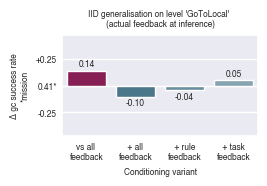

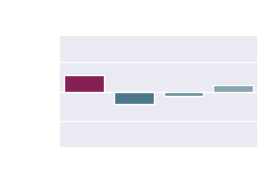

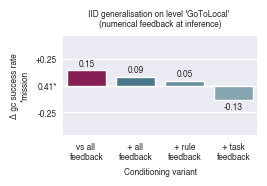

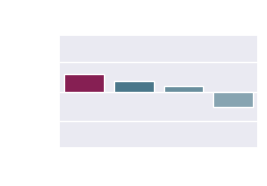

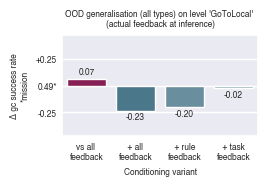

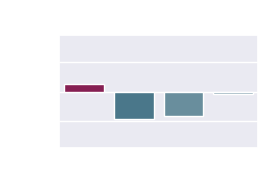

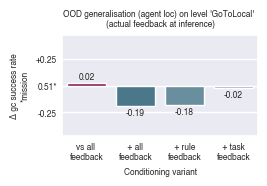

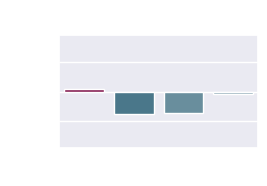

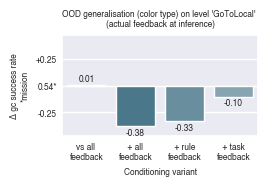

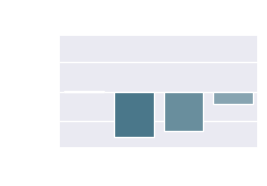

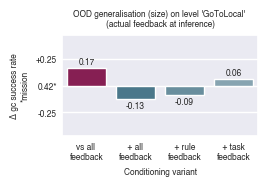

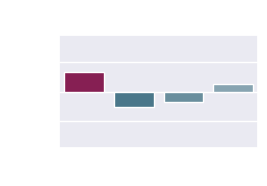

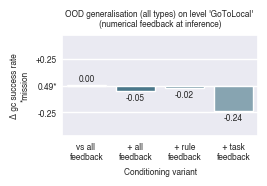

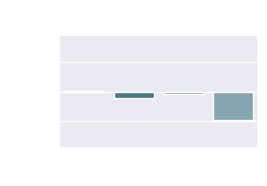

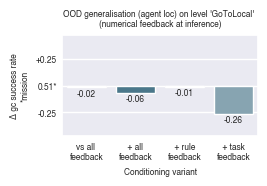

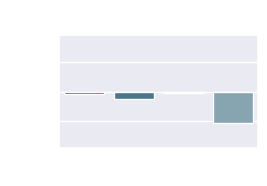

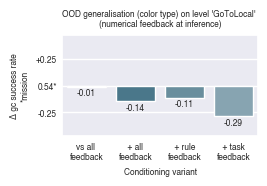

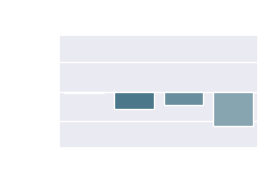

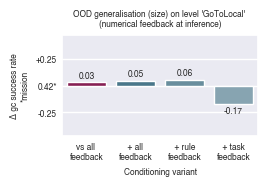

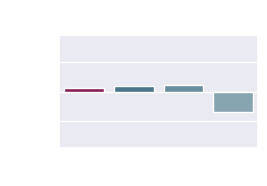

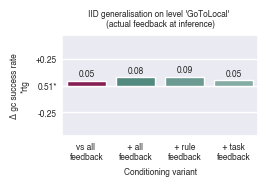

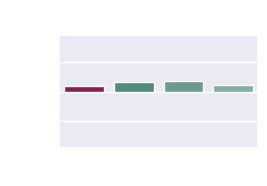

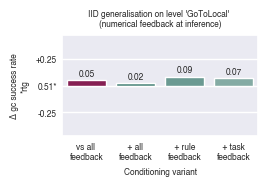

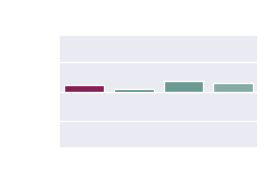

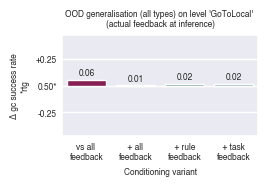

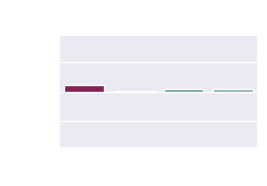

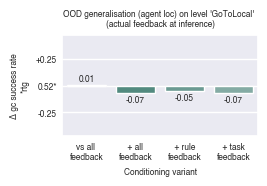

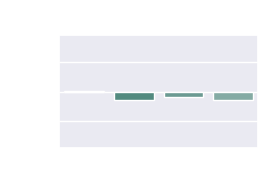

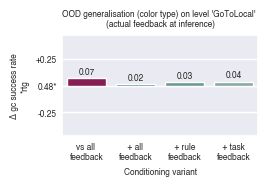

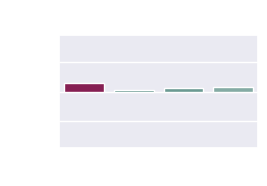

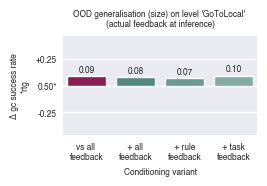

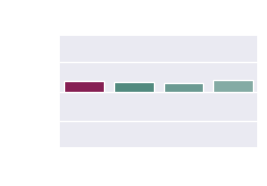

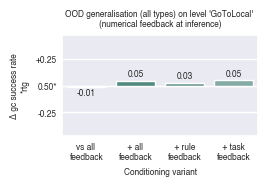

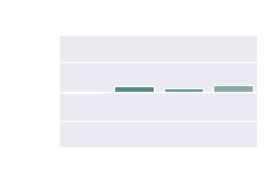

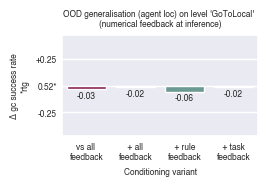

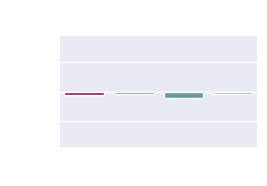

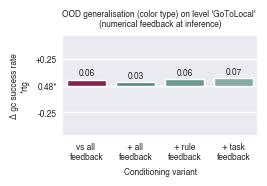

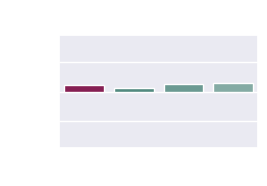

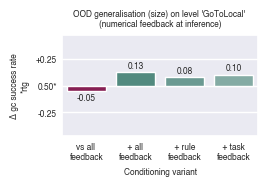

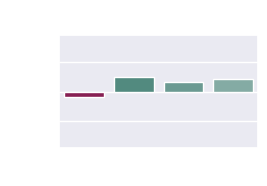

GOTOOBJ


,conditioning,eval_type,ood_type,feedback_at_inference,diff
74,rtg + task feedback,ood_generalisation,size,numerical,0.000000
99,rtg + task feedback,ood_generalisation,size,actual,-0.328125
69,rtg + task feedback,ood_generalisation,color_type,numerical,0.000000
94,rtg + task feedback,ood_generalisation,color_type,actual,-0.242188
59,rtg + task feedback,ood_generalisation,all types,numerical,0.000000
84,rtg + task feedback,ood_generalisation,all types,actual,-0.205729
64,rtg + task feedback,ood_generalisation,agent_loc,numerical,0.000000
89,rtg + task feedback,ood_generalisation,agent_loc,actual,-0.046875
54,rtg + task feedback,iid_generalisation,None,numerical,0.000000
79,rtg + task feedback,iid_generalisation,None,actual,-0.140625


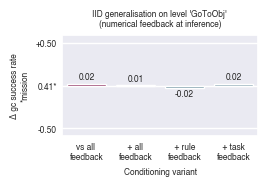

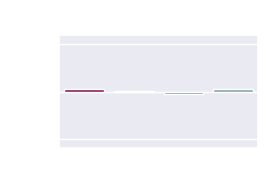

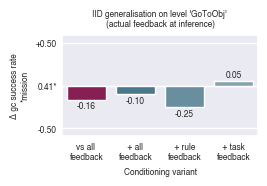

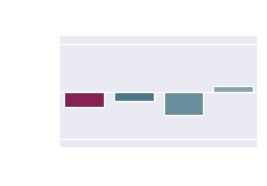

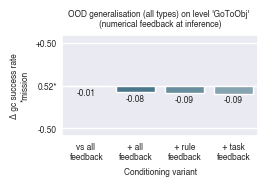

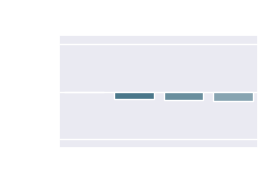

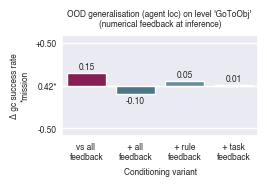

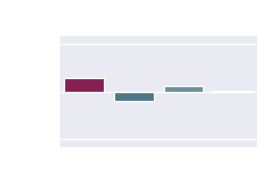

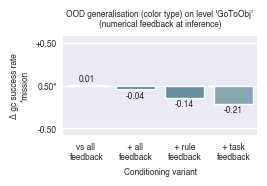

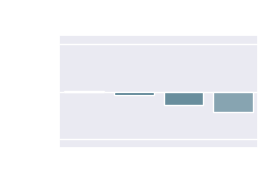

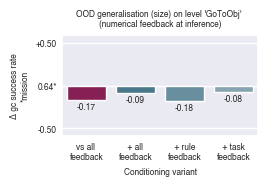

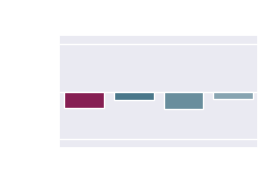

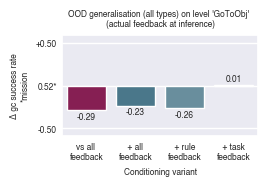

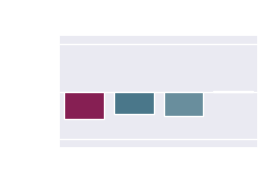

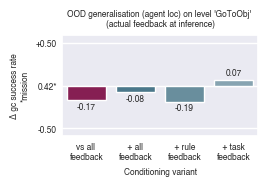

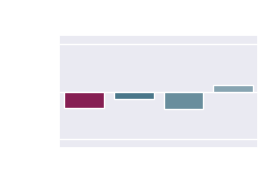

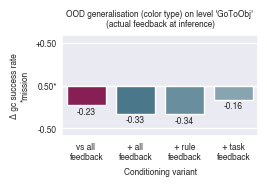

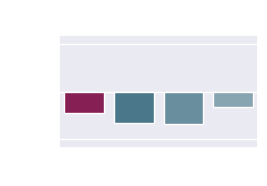

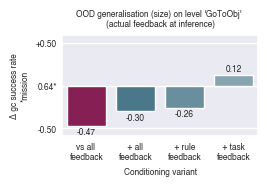

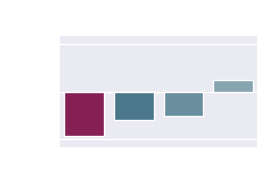

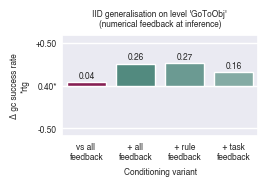

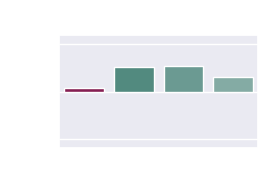

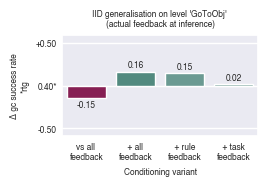

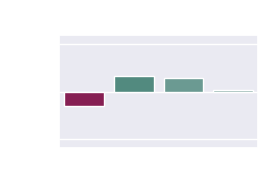

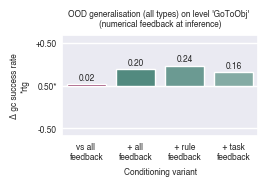

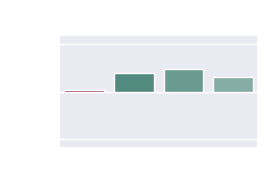

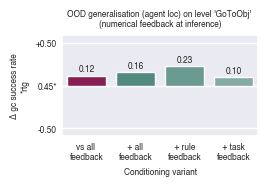

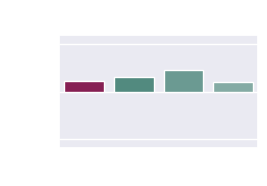

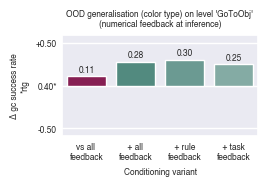

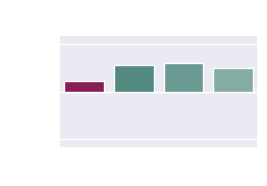

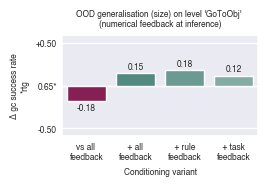

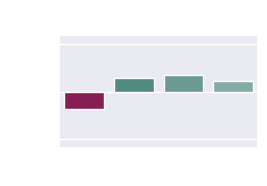

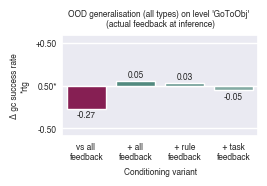

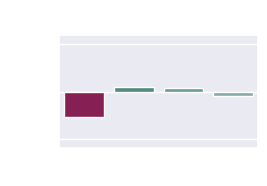

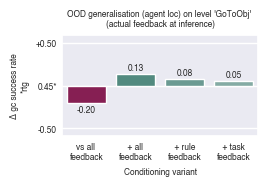

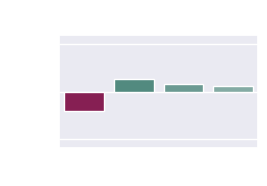

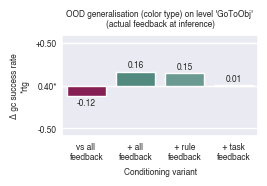

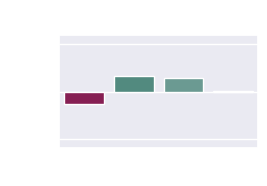

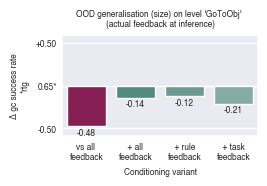

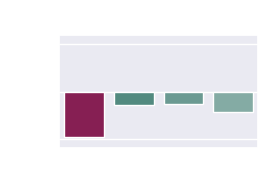

PICKUPLOC


,conditioning,eval_type,ood_type,feedback_at_inference,diff
99,rtg + task feedback,ood_generalisation,rel_loc,numerical,0.000000
74,rtg + task feedback,ood_generalisation,rel_loc,actual,-0.023438
94,rtg + task feedback,ood_generalisation,color_type,numerical,0.000000
69,rtg + task feedback,ood_generalisation,color_type,actual,0.042969
84,rtg + task feedback,ood_generalisation,all types,numerical,0.000000
59,rtg + task feedback,ood_generalisation,all types,actual,0.014323
89,rtg + task feedback,ood_generalisation,agent_loc,numerical,0.000000
64,rtg + task feedback,ood_generalisation,agent_loc,actual,0.023438
79,rtg + task feedback,iid_generalisation,None,numerical,0.000000
54,rtg + task feedback,iid_generalisation,None,actual,0.003906


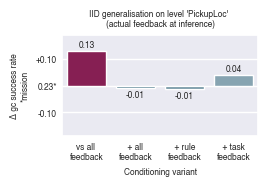

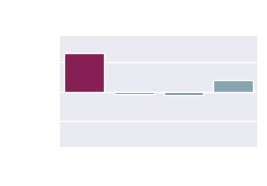

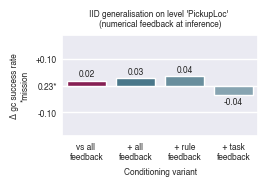

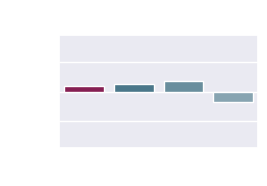

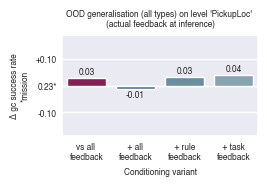

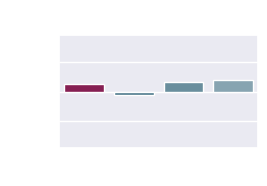

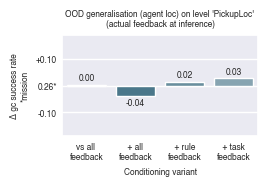

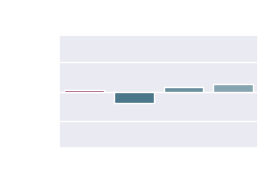

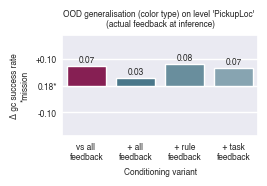

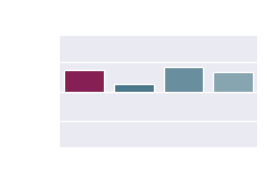

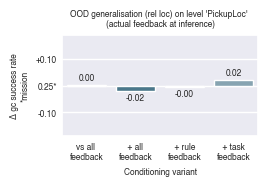

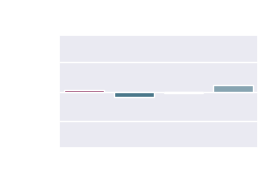

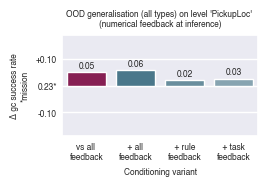

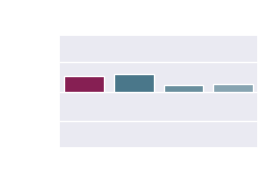

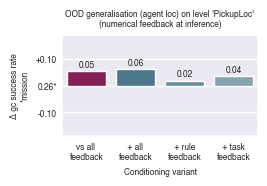

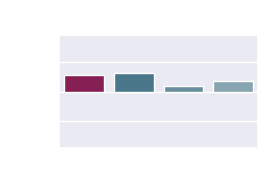

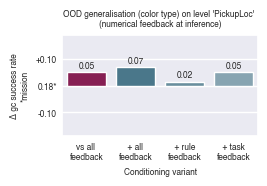

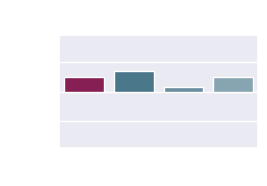

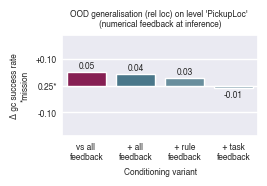

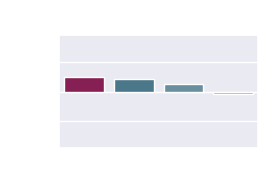

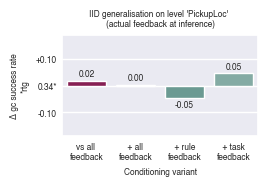

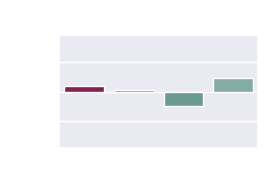

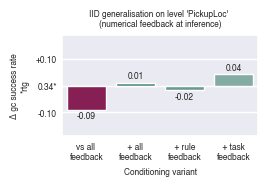

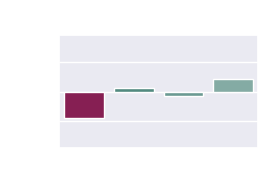

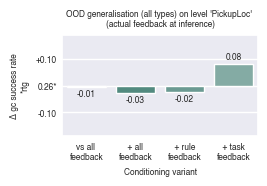

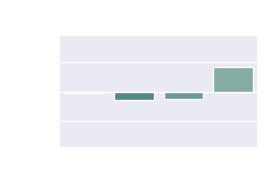

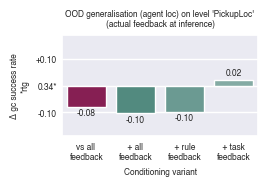

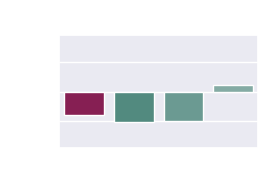

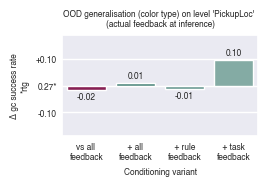

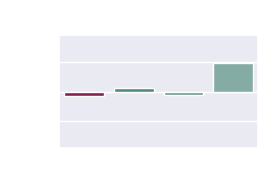

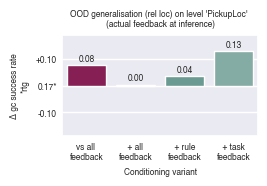

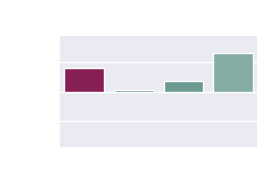

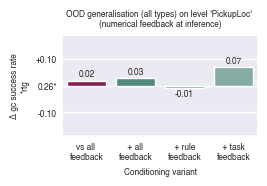

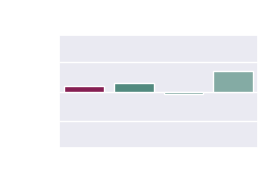

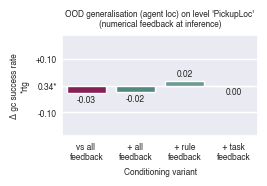

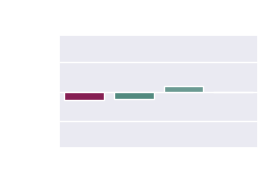

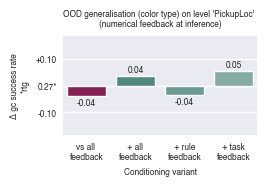

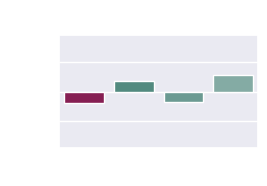

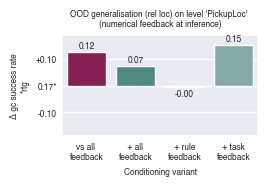

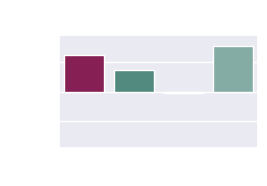

PUTNEXTLOCAL


,conditioning,eval_type,ood_type,feedback_at_inference,diff
89,rtg + task feedback,ood_generalisation,size,numerical,0.000000
119,rtg + task feedback,ood_generalisation,size,actual,-0.095703
84,rtg + task feedback,ood_generalisation,object_task,numerical,0.000000
114,rtg + task feedback,ood_generalisation,object_task,actual,-0.068359
79,rtg + task feedback,ood_generalisation,color_type,numerical,0.000000
109,rtg + task feedback,ood_generalisation,color_type,actual,-0.048828
69,rtg + task feedback,ood_generalisation,all types,numerical,0.000000
99,rtg + task feedback,ood_generalisation,all types,actual,-0.067383
74,rtg + task feedback,ood_generalisation,agent_loc,numerical,0.000000
104,rtg + task feedback,ood_generalisation,agent_loc,actual,-0.056641


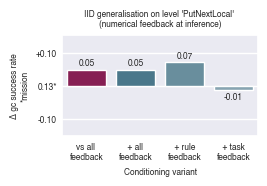

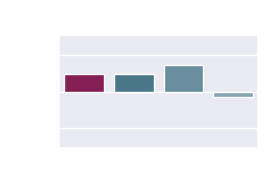

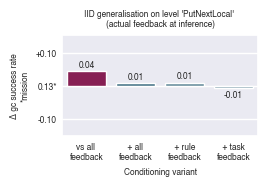

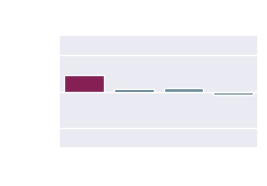

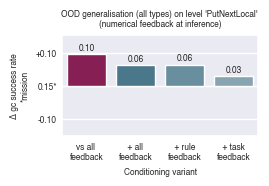

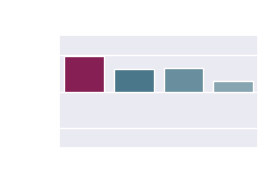

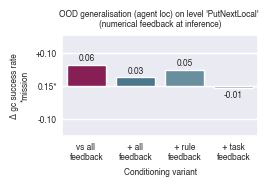

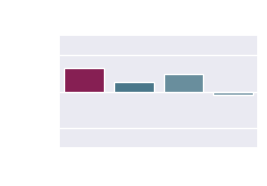

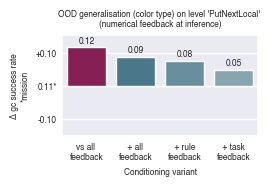

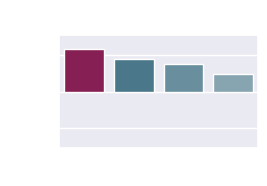

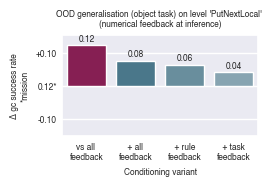

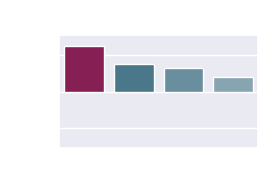

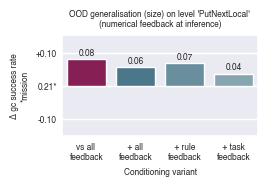

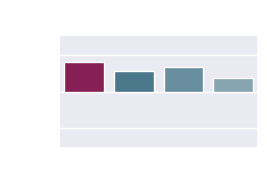

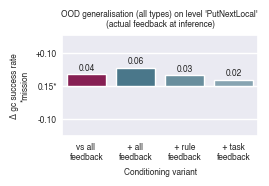

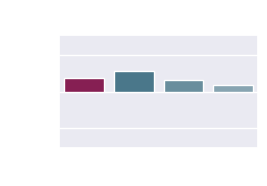

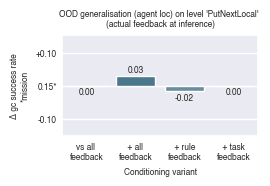

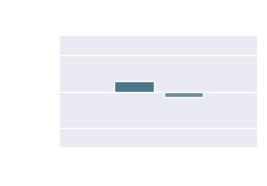

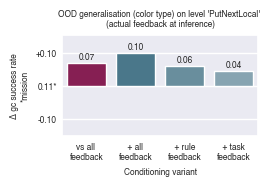

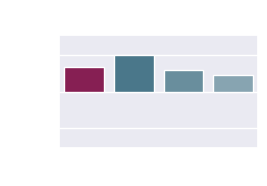

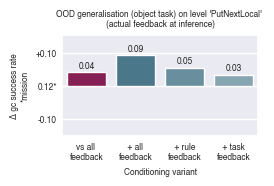

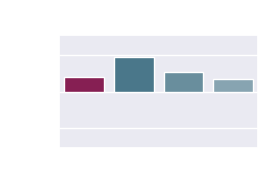

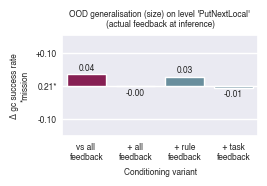

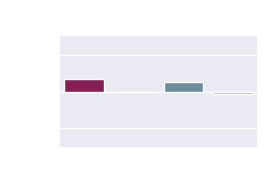

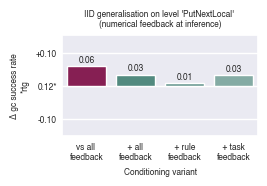

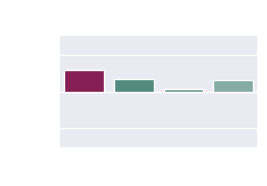

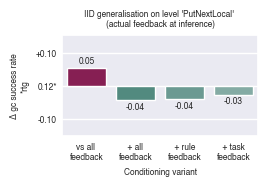

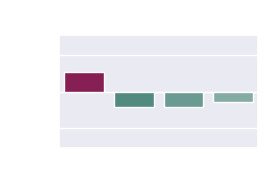

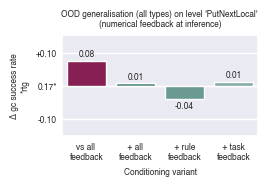

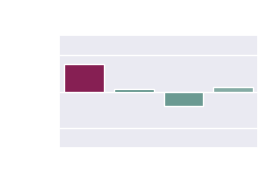

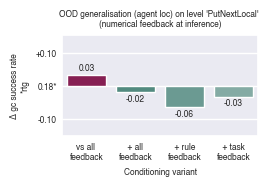

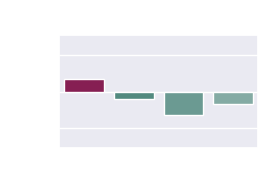

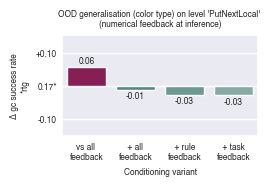

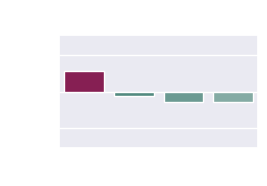

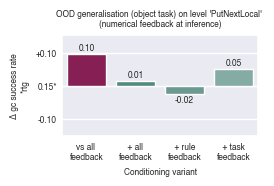

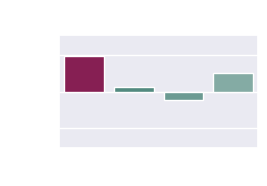

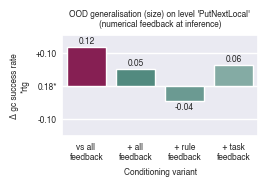

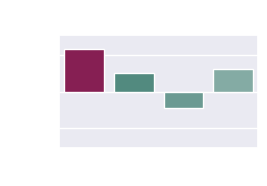

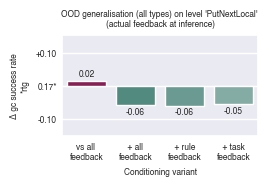

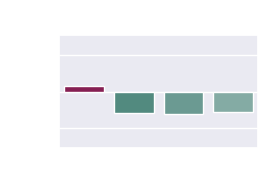

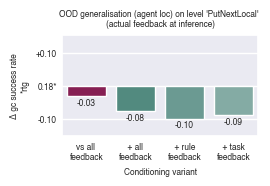

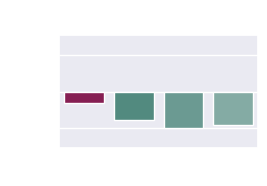

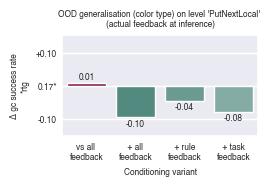

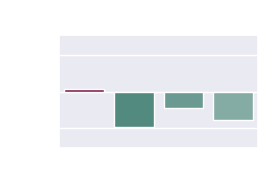

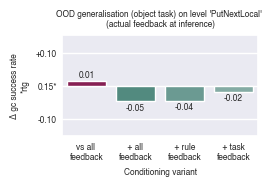

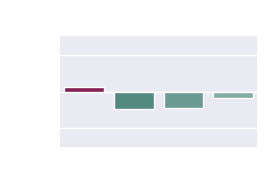

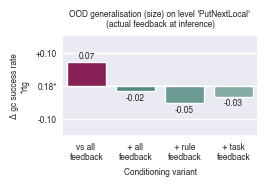

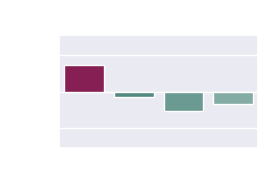

ALL LEVELS


,conditioning,eval_type,ood_type,feedback_at_inference,diff
139,rtg + task feedback,ood_generalisation,size,numerical,0.000000
104,rtg + task feedback,ood_generalisation,size,actual,-0.144634
134,rtg + task feedback,ood_generalisation,rel_loc,numerical,0.000000
99,rtg + task feedback,ood_generalisation,rel_loc,actual,-0.023438
129,rtg + task feedback,ood_generalisation,object_task,numerical,0.000000
94,rtg + task feedback,ood_generalisation,object_task,actual,-0.068359
124,rtg + task feedback,ood_generalisation,color_type,numerical,0.000000
89,rtg + task feedback,ood_generalisation,color_type,actual,-0.070098
114,rtg + task feedback,ood_generalisation,all types,numerical,0.000000
79,rtg + task feedback,ood_generalisation,all types,actual,-0.072376


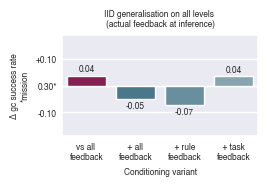

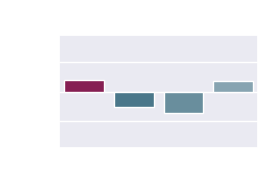

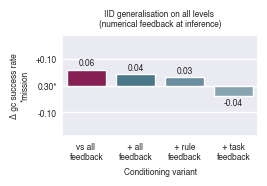

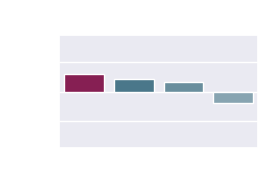

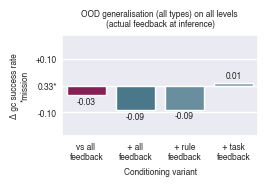

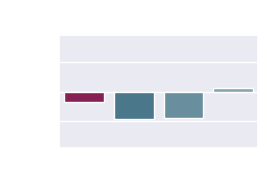

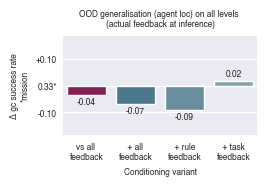

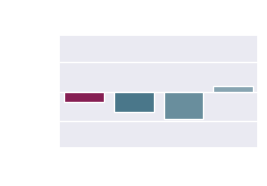

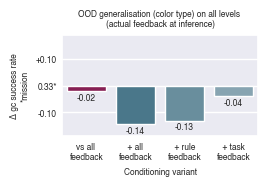

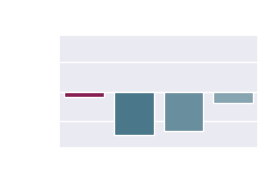

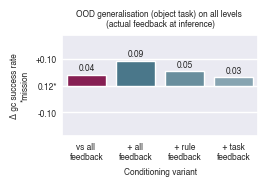

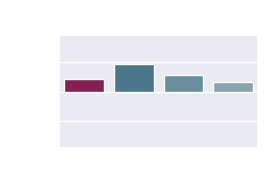

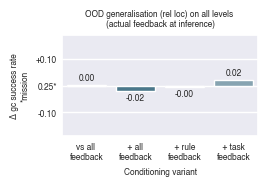

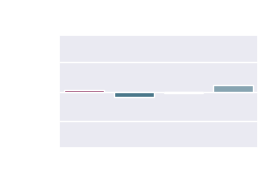

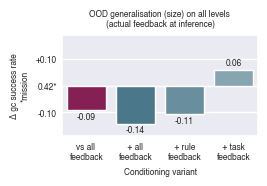

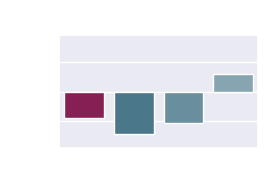

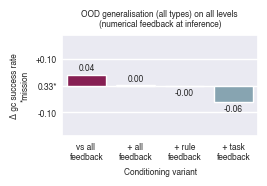

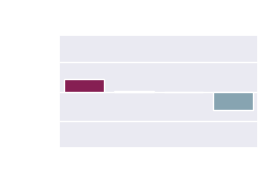

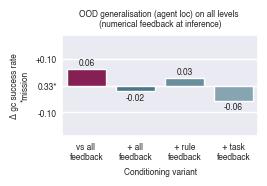

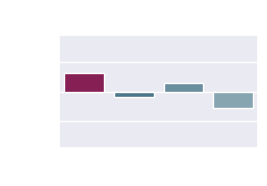

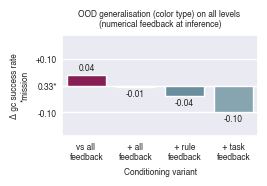

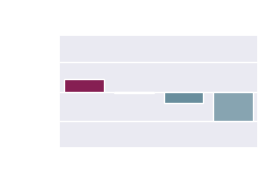

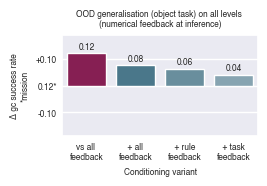

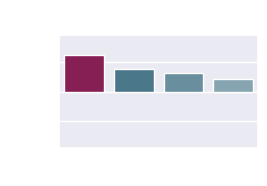

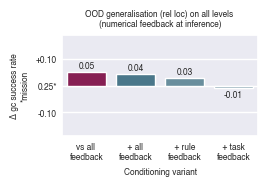

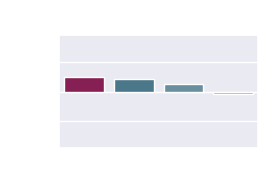

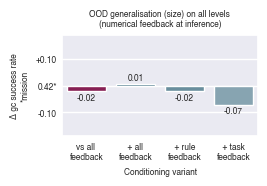

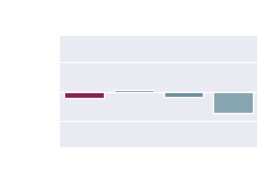

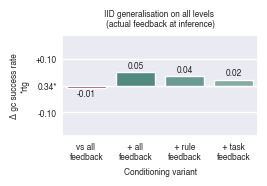

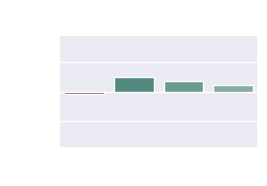

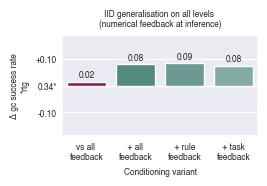

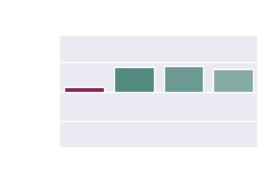

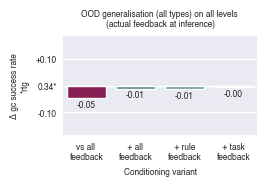

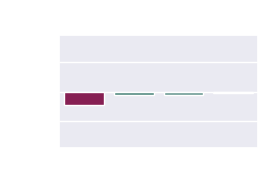

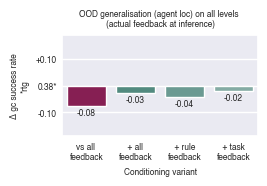

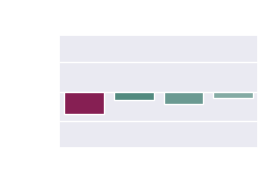

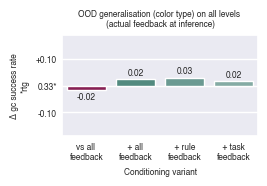

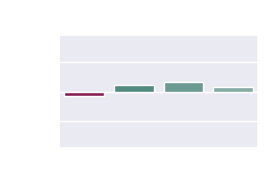

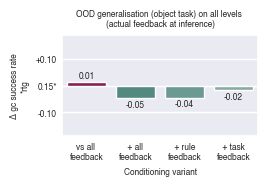

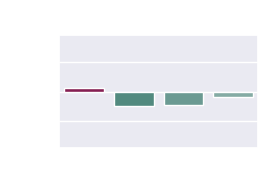

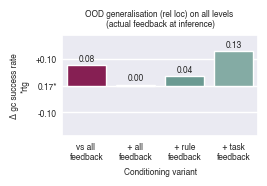

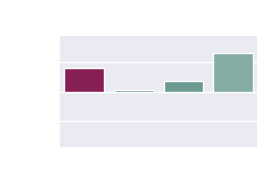

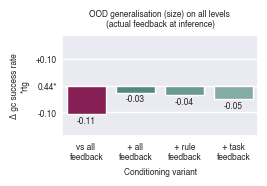

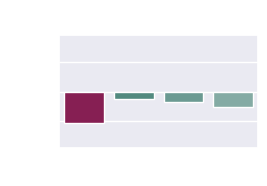

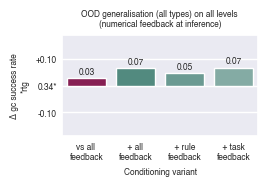

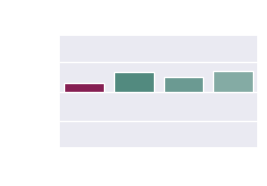

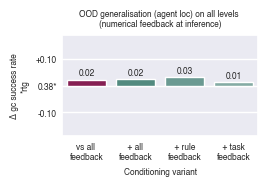

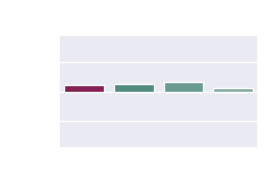

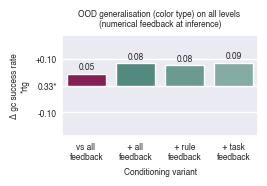

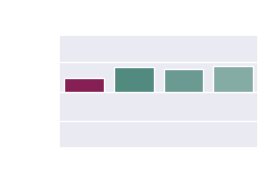

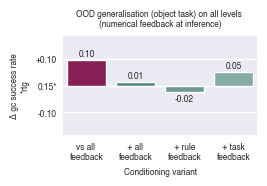

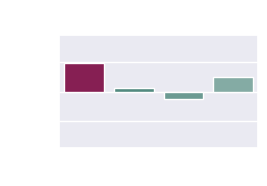

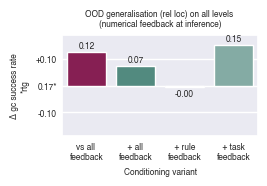

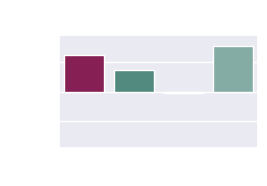

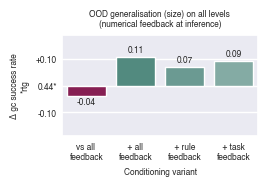

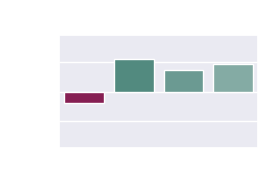

In [3298]:
comb_df = get_combined_df(data_home, level="")
for level in sorted(comb_df["level"].unique()):
    print(level.upper())
    level_df = comb_df[comb_df["level"] == level]
    results_df = combine_results(level_df, metric)
    get_inference_mode_diffs(results_df)
    save_results_as_csv(results_df, level, metric, output_path)
    plot_results(results_df, level, metric, colors, size, output_path)
    print("===" * 10)

print("ALL LEVELS")
results_df = combine_results(comb_df, metric)
get_inference_mode_diffs(results_df)
save_results_as_csv(results_df, "all_levels", metric, output_path)
plot_results(results_df, "all_levels", metric, colors, size, output_path)